<a href="https://colab.research.google.com/github/gayathri428/E-Commerce-Sales-analysis-for-Data-Driven-Making--TASK--4/blob/main/Task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from google.colab import files  # use this if you upload via Colab UI

In [2]:
# 1) Upload file via Colab UI and set filename, or point to Drive path
# uploaded = files.upload()  # use this to upload interactively
# input_path = list(uploaded.keys())[0]

# If you already placed the file in Drive, set its path, e.g.:
# input_path = "/content/drive/MyDrive/Cleaned_Amazon_Sales_Dataset (1).csv"
input_path = "Cleaned_Amazon_Sales_Dataset (1).csv"  # change if needed

df = pd.read_csv(input_path, low_memory=False)

# Auto-detect sensible date & sales columns (you can override below) ===
# Preferred override (if you know): date_col = "Order Date"; sales_col = "Total Sales Revenue"
date_col = "Order Date"
sales_col = "Total Sales Revenue"


print("Using date column:", date_col)
print("Using sales column:", sales_col)

Using date column: Order Date
Using sales column: Total Sales Revenue


In [3]:
# 2) Convert date to datetime, clean sales numeric
df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
df[sales_col] = pd.to_numeric(df[sales_col].astype(str).str.replace('[^0-9\.\-]', '', regex=True), errors='coerce')

<>:3: SyntaxWarning: invalid escape sequence '\.'
<>:3: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipython-input-1926103152.py:3: SyntaxWarning: invalid escape sequence '\.'
  df[sales_col] = pd.to_numeric(df[sales_col].astype(str).str.replace('[^0-9\.\-]', '', regex=True), errors='coerce')
/tmp/ipython-input-1926103152.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[date_col] = pd.to_datetime(df[date_col], errors='coerce')


In [4]:
# 3) Drop rows without date and aggregate to daily totals
df = df.dropna(subset=[date_col]).copy()
df['date_only'] = df[date_col].dt.date
daily = df.groupby('date_only', as_index=True)[sales_col].sum().rename("daily_sales").to_frame()
daily.index = pd.to_datetime(daily.index)
daily = daily.sort_index()

In [5]:
# 4) Ensure a full daily index and fill missing dates with 0 (change strategy if you prefer)
full_idx = pd.date_range(start=daily.index.min(), end=daily.index.max(), freq='D')
daily = daily.reindex(full_idx)
daily.index.name = "date"
daily['daily_sales'] = daily['daily_sales'].fillna(0)

In [6]:
# 5) Rolling stats and simple anomaly flag (sales > mean + 3*std over 7-day window)
daily['rolling_mean_7d'] = daily['daily_sales'].rolling(7, min_periods=1).mean()
daily['rolling_std_7d'] = daily['daily_sales'].rolling(7, min_periods=1).std().fillna(0)
daily['anomaly'] = daily['daily_sales'] > (daily['rolling_mean_7d'] + 3 * daily['rolling_std_7d'])

In [7]:
# 6) Weekly (Mon-start) and Monthly aggregates
weekly = daily['daily_sales'].resample('W-MON').sum().rename('weekly_sales').to_frame()
monthly = daily['daily_sales'].resample('M').sum().rename('monthly_sales').to_frame()


/tmp/ipython-input-2880496213.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = daily['daily_sales'].resample('M').sum().rename('monthly_sales').to_frame()


In [8]:
# 7) Save outputs
daily_path = "/content/processed_daily_sales.csv"
weekly_path = "/content/processed_weekly_sales.csv"
monthly_path = "/content/processed_monthly_sales.csv"
daily.to_csv(daily_path, index=True)
weekly.to_csv(weekly_path, index=True)
monthly.to_csv(monthly_path, index=True)


In [9]:
print("Saved:", daily_path, weekly_path, monthly_path)
print("Date range:", daily.index.min().date(), "to", daily.index.max().date())
print("Total sales:", daily['daily_sales'].sum(), "Anomaly days:", daily['anomaly'].sum())

Saved: /content/processed_daily_sales.csv /content/processed_weekly_sales.csv /content/processed_monthly_sales.csv
Date range: 2019-01-01 to 2024-12-31
Total sales: 6902611.93 Anomaly days: 0


In [10]:
# optional: download files to your machine
# files.download(daily_path)
# files.download(weekly_path)
# files.download(monthly_path)


In [11]:
!pip install prophet matplotlib pandas scikit-learn

In [12]:
# 1. Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

In [13]:
# 2. Load Dataset
file_path = "/content/Cleaned_Amazon_Sales_Dataset (1).csv"  # Update if path differs
df = pd.read_csv(file_path)
# Check first few rows
print(df.head())

                               Order ID  Order Date  \
0  ffea84e6-e053-4826-a5a6-e38ab81c2ddf  26-08-2021   
1  ffe7dab6-a8bd-48a9-9edc-48e9bb7d2b02  18-02-2023   
2  ffe0be9a-ffac-407e-a3ca-543cab8b25e6  28-06-2021   
3  ffd6b1d4-72e9-458c-8925-6c513bb7ca28  14-12-2022   
4  ffcfe410-b778-4e56-a405-a9e85cb265d6  28-08-2023   

                            Customer ID Customer Name         Location  \
0  3c4d31fe-6cb6-405c-981f-0c4c2ee223a0    Riya Desai   Mumbai (Urban)   
1  644d7a99-daa8-49a0-a02f-bcab42cdb8be  Sanjay Reddy   Mumbai (Urban)   
2  44579d98-e939-464a-8919-f2c8342f81fe    Divya Iyer  Chennai (Urban)   
3  da67565b-0608-4ea1-bfec-296c47933d2c    Neha Singh  Chennai (Urban)   
4  3fb1f133-52a0-4ab9-8c6d-20a7d622842a     Riya Shah     Pune (Urban)   

  Product Category             Product Name  Quantity Sold  Unit Price  \
0            Books  The Immortals of Meluha              5      284.74   
1   Home & Kitchen           Non-Stick Tawa              8      193.65   
2 

In [14]:
# 3. Prepare Data for Prophet
# Assuming dataset has columns like 'Order Date' and 'Sales'
# Convert date column to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d-%m-%Y')

# Group daily sales
sales_df = df.groupby('Order Date')['Total Sales'].sum().reset_index()

# Prophet expects 'ds' and 'y' column names
sales_df.rename(columns={'Order Date': 'ds', 'Total Sales': 'y'}, inplace=True)

print(sales_df.head())


          ds        y
0 2019-01-01  5107.64
1 2019-01-02  1094.58
2 2019-01-04  3848.42
3 2019-01-05  3702.04
4 2019-01-07  3730.89


In [15]:
# 4. Train/Test Split
train_size = int(len(sales_df) * 0.8)
train_df = sales_df.iloc[:train_size]
test_df = sales_df.iloc[train_size:]

In [16]:
# 5. Train Prophet Model
model = Prophet(yearly_seasonality=True, daily_seasonality=False, weekly_seasonality=True)
model.fit(train_df)

DEBUG:cmdstanpy:input tempfile: /tmp/tmpdq6mh81u/pvdii2rp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpdq6mh81u/z4w5ciu7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13432', 'data', 'file=/tmp/tmpdq6mh81u/pvdii2rp.json', 'init=/tmp/tmpdq6mh81u/z4w5ciu7.json', 'output', 'file=/tmp/tmpdq6mh81u/prophet_modelg8eho928/prophet_model-20250824165719.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:57:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:57:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [17]:
# 6. Forecast Future
future = model.make_future_dataframe(periods=len(test_df), freq='D')
forecast = model.predict(future)

In [18]:
# 7. Evaluate Model
# Align test data with forecast
merged_df = pd.merge(test_df, forecast[['ds', 'yhat']], on='ds', how='left')
# Fill missing forecast values with 0
merged_df['yhat'] = merged_df['yhat'].fillna(0)
rmse = np.sqrt(mean_squared_error(merged_df['y'], merged_df['yhat']))
mape = mean_absolute_percentage_error(merged_df['y'], merged_df['yhat']) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 2343.83
MAPE: 205.40%


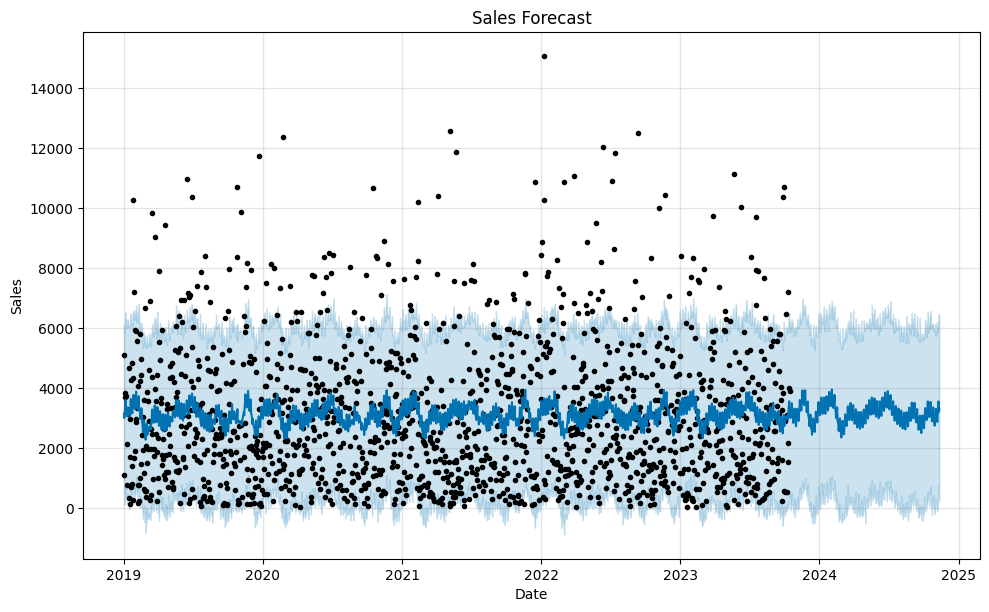

In [19]:
# 8. Visualize Forecast
fig1 = model.plot(forecast)
plt.title("Sales Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

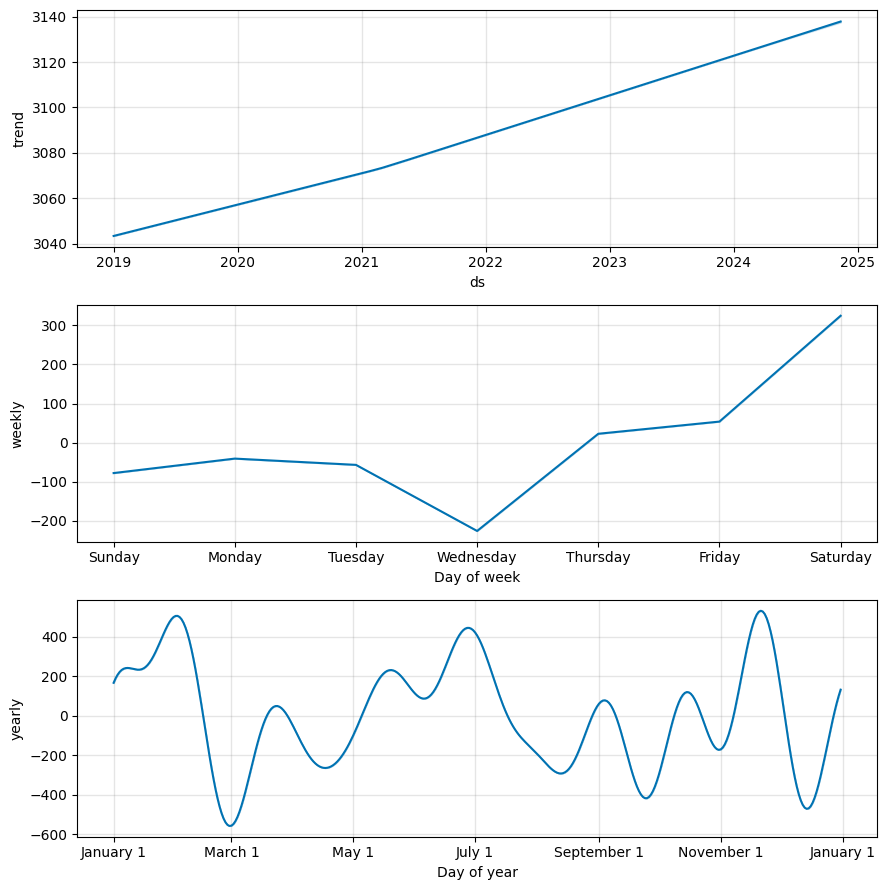

In [20]:
# 9. Visualize Forecast Components
fig2 = model.plot_components(forecast)
plt.show()

In [21]:
# (A) Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import os

# CONFIG
FILE_PATH = "/content/Cleaned_Amazon_Sales_Dataset (1).csv"  # <- change if needed
FORECAST_HORIZON_MONTHS = 12      # set to 6 or 12
OUTPUT_DIR = "/content/forecast_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [22]:
# (B) Load & prepare data (uses Order Date, Total Sales with DD-MM-YYYY)
df = pd.read_csv(FILE_PATH)
df["Order Date"] = pd.to_datetime(df["Order Date"], format="%d-%m-%Y", errors="coerce")
df = df.dropna(subset=["Order Date"])
df["Total Sales"] = pd.to_numeric(df["Total Sales"], errors="coerce")
df = df.dropna(subset=["Total Sales"])

# Monthly aggregation (Month Start)
monthly = df.set_index("Order Date").resample("MS")["Total Sales"].sum().to_frame("y")
monthly.index.name = "ds"

In [23]:
# (C) Train/Test Split (80/20 in time)
n = len(monthly)
train_size = int(n * 0.8)
train, test = monthly.iloc[:train_size].copy(), monthly.iloc[train_size:].copy()
y_train, y_test = train["y"], test["y"]

In [24]:
# (D) Train Holt-Winters (Additive Trend + Additive Seasonality, period=12)
model = ExponentialSmoothing(
    y_train,
    trend="add",
    seasonal="add",
    seasonal_periods=12,
    initialization_method="estimated"
)
fit = model.fit(optimized=True)

In [25]:
# (E) Predict on test to validate
pred_test = fit.forecast(steps=len(test))
rmse = sqrt(mean_squared_error(y_test.values, pred_test.values))
mape = mean_absolute_percentage_error(y_test.values, pred_test.values) * 100

print(f"[Validation] Test RMSE: {rmse:,.2f}")
print(f"[Validation] Test MAPE: {mape:.2f}%")

[Validation] Test RMSE: 16,920.08
[Validation] Test MAPE: 18.53%


In [26]:
# (F) Refit on ALL data and Forecast next 6–12 months
full_model = ExponentialSmoothing(
    monthly["y"], trend="add", seasonal="add", seasonal_periods=12, initialization_method="estimated"
).fit(optimized=True)

future = full_model.forecast(steps=FORECAST_HORIZON_MONTHS)
future_index = pd.date_range(monthly.index.max() + pd.offsets.MonthBegin(1),
                             periods=FORECAST_HORIZON_MONTHS, freq="MS")
forecast_df = pd.DataFrame({"ds": future_index, "yhat": future.values})

In [27]:
# (G) Save CSV
csv_path = os.path.join(OUTPUT_DIR, f"monthly_sales_forecast_next_{FORECAST_HORIZON_MONTHS}m.csv")
forecast_df.to_csv(csv_path, index=False)
print("Saved forecast CSV ->", csv_path)

Saved forecast CSV -> /content/forecast_outputs/monthly_sales_forecast_next_12m.csv


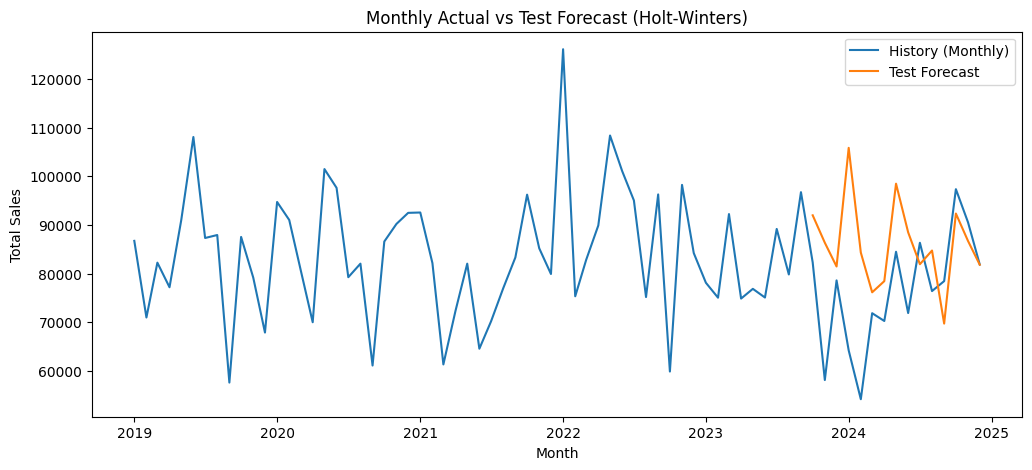

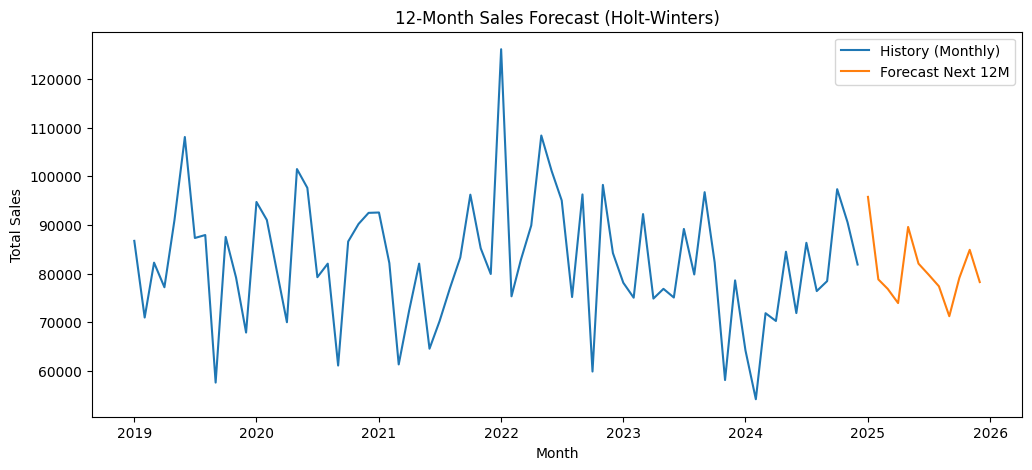

In [28]:
# (H) Visualizations (history vs test; history vs future)
plt.figure(figsize=(12,5))
plt.plot(monthly.index, monthly["y"], label="History (Monthly)")
plt.plot(test.index, pred_test.values, label="Test Forecast")
plt.title("Monthly Actual vs Test Forecast (Holt-Winters)")
plt.xlabel("Month"); plt.ylabel("Total Sales"); plt.legend()
plot1 = os.path.join(OUTPUT_DIR, "actual_vs_test_forecast.png")
plt.savefig(plot1, dpi=120, bbox_inches="tight")
plt.show()

plt.figure(figsize=(12,5))
plt.plot(monthly.index, monthly["y"], label="History (Monthly)")
plt.plot(forecast_df["ds"], forecast_df["yhat"], label=f"Forecast Next {FORECAST_HORIZON_MONTHS}M")
plt.title(f"12-Month Sales Forecast (Holt-Winters)")
plt.xlabel("Month"); plt.ylabel("Total Sales"); plt.legend()
plot2 = os.path.join(OUTPUT_DIR, "forecast_next_months.png")
plt.savefig(plot2, dpi=120, bbox_inches="tight")
plt.show()

In [29]:
# (I) Simple Business Analysis
hist_last_12 = monthly.tail(12)["y"].sum() if len(monthly) >= 12 else monthly["y"].sum()
fcast_next_horizon = forecast_df["yhat"].sum()

growth_abs = fcast_next_horizon - hist_last_12
growth_pct = (growth_abs / hist_last_12 * 100) if hist_last_12 != 0 else np.nan

# Top 3 forecasted months (peaks) & Bottom 3 (slumps)
top3 = forecast_df.nlargest(3, "yhat")[["ds", "yhat"]]
bottom3 = forecast_df.nsmallest(3, "yhat")[["ds", "yhat"]]

print("\n=== Business Summary ===")
print(f"Expected total sales next {FORECAST_HORIZON_MONTHS} months: {fcast_next_horizon:,.0f}")
print(f"Last 12 months total (history): {hist_last_12:,.0f}")
print(f"Projected change: {growth_abs:,.0f} ({growth_pct:.2f}%)")

print("\nPeak months to prepare inventory/ads:")
for _, r in top3.sort_values("ds").iterrows():
    print(f" - {r['ds'].strftime('%b %Y')}: {r['yhat']:,.0f}")

print("\nSlow months—consider promos/discounts:")
for _, r in bottom3.sort_values("ds").iterrows():
    print(f" - {r['ds'].strftime('%b %Y')}: {r['yhat']:,.0f}")


=== Business Summary ===
Expected total sales next 12 months: 967,814
Last 12 months total (history): 927,985
Projected change: 39,829 (4.29%)

Peak months to prepare inventory/ads:
 - Jan 2025: 95,766
 - May 2025: 89,592
 - Nov 2025: 84,893

Slow months—consider promos/discounts:
 - Mar 2025: 76,874
 - Apr 2025: 73,954
 - Sep 2025: 71,258


In [30]:
# (J) Optional: Export a concise text report
report = f"""
Subtask 3 – Sales Forecast Summary
Model: Holt-Winters (Additive Trend + Additive Seasonality, period=12)
Validation (80/20 split): RMSE={rmse:,.2f}, MAPE={mape:.2f}%

Forecast horizon: {FORECAST_HORIZON_MONTHS} months
Expected total (forecast): {fcast_next_horizon:,.0f}
Last 12 months (history): {hist_last_12:,.0f}
Projected change: {growth_abs:,.0f} ({growth_pct:.2f}%)

Top peak months:
{top3.to_string(index=False)}

Slow months:
{bottom3.to_string(index=False)}

Recommendations:
• Stock up 6–8 weeks before peak months; secure logistics & warehouse capacity.
• Increase ad spend & festive bundles in peak months; run retargeting on high-intent audiences.
• Plan price promos/loyalty offers for slow months; push category-specific deals.
• Monitor actuals monthly; retrain model quarterly or after major events.
""".strip()

report_path = os.path.join(OUTPUT_DIR, "subtask3_forecast_summary.txt")
with open(report_path, "w") as f:
    f.write(report)
print("\nSaved summary ->", report_path)



Saved summary -> /content/forecast_outputs/subtask3_forecast_summary.txt


In [31]:
# (K) Show first rows of forecast
forecast_df.head(12)

,ds,yhat
0,2025-01-01,95766.155802
1,2025-02-01,78818.128921
2,2025-03-01,76873.691456
3,2025-04-01,73954.237450
4,2025-05-01,89592.222432
5,2025-06-01,82057.445651
6,2025-07-01,79812.752647
7,2025-08-01,77402.796531
8,2025-09-01,71258.032054
9,2025-10-01,79116.459732


In [32]:
# Colab-ready: Full Subtask 4 + extras (CI, heatmap, bar chart, PDF + DOCX + exec summary)
# Paste into a single Colab cell and run.

# Install required packages
!pip install --quiet pandas matplotlib seaborn statsmodels python-docx reportlab

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.1 MB/s eta 0:00:00


In [33]:
# Imports
import pandas as pd, numpy as np, os, matplotlib.pyplot as plt, seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from datetime import datetime
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image as RLImage
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import A4
from docx import Document
from docx.shared import Inches

In [34]:
from google.colab import files
import pandas as pd

# Prompt user to upload
print("📂 Please upload your dataset file (CSV or Excel)...")
uploaded = files.upload()

# Get filename from uploaded dict
for filename in uploaded.keys():
    print("✅ Uploaded file:", filename)

# Load CSV
if filename.endswith('.csv'):
    df = pd.read_csv(filename)
elif filename.endswith(('.xls', '.xlsx')):
    df = pd.read_excel(filename)
else:
    raise ValueError("Unsupported file format. Please upload CSV or Excel.")

# Preview data
print("✅ File loaded successfully with shape:", df.shape)

📂 Please upload your dataset file (CSV or Excel)...


Saving Cleaned_Amazon_Sales_Dataset (1).csv to Cleaned_Amazon_Sales_Dataset (1) (1).csv
✅ Uploaded file: Cleaned_Amazon_Sales_Dataset (1) (1).csv
✅ File loaded successfully with shape: (5000, 19)


In [35]:
# Try common date & sales column names
date_candidates = ['Order Date','OrderDate','Date','order date','order_date','Order_Date']
sales_candidates = ['Total Sales','Sales','TotalSales','Revenue','total_sales','total sales']

date_col = None
sales_col = None
for c in date_candidates:
    if c in df.columns:
        date_col = c
        break
for c in sales_candidates:
    if c in df.columns:
        sales_col = c
        break

if date_col is None or sales_col is None:
    print("Columns in CSV:", df.columns.tolist())
    raise SystemExit("Couldn't find a suitable date or sales column. Ensure CSV has 'Order Date' and 'Total Sales' or similar.")

# Parse date (dataset used DD-MM-YYYY earlier)
# Try common formats
for fmt in ("%d-%m-%Y","%Y-%m-%d","%m/%d/%Y","%d/%m/%Y"):
    try:
        df[date_col] = pd.to_datetime(df[date_col], format=fmt)
        break
    except Exception:
        df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
# drop NaT
df = df.dropna(subset=[date_col])
df[sales_col] = pd.to_numeric(df[sales_col], errors='coerce')
df = df.dropna(subset=[sales_col])

In [36]:
# Aggregate to monthly (Month Start)
df = df.sort_values(date_col)
monthly = df.set_index(date_col).resample('MS')[sales_col].sum().to_frame('y')
monthly.index.name = 'ds'

In [37]:
# Train/test split (80/20 time-based). We'll validate on last N months (min 6)
n = len(monthly)
test_months = max(6, int(n * 0.2))
train = monthly.iloc[:-test_months]
test = monthly.iloc[-test_months:]

y_train = train['y']; y_test = test['y']

In [38]:
# Fit Holt-Winters (monthly seasonality=12) on train
hw = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=12, initialization_method='estimated')
hw_fit = hw.fit(optimized=True)

In [39]:
# Forecast on test and compute residuals to estimate sigma for CI
pred_test = hw_fit.forecast(steps=len(test))
residuals = y_train.values - hw_fit.fittedvalues.values
resid_std = np.std(residuals, ddof=1)  # sample std
z95 = 1.96

In [40]:
# Compute metrics on test
rmse = sqrt(mean_squared_error(y_test.values, pred_test.values))
mae = mean_absolute_error(y_test.values, pred_test.values)
# MAPE: handle zeros safely
mape = np.mean(np.abs((y_test.values - pred_test.values) / np.where(y_test.values==0, np.nan, y_test.values))) * 100
mape = np.nanmean(mape) if np.isfinite(mape) else np.nan
# fallback if nan
if np.isnan(mape): mape = np.mean(np.abs((y_test.values - pred_test.values))) / max(1, np.mean(y_test.values)) * 100

In [41]:
# Refit on full data and produce 6 & 12 month forecasts
full_model = ExponentialSmoothing(monthly['y'], trend='add', seasonal='add', seasonal_periods=12, initialization_method='estimated').fit(optimized=True)
h6 = 6; h12 = 12
fc6 = full_model.forecast(steps=h6)
fc12 = full_model.forecast(steps=h12)
last_date = monthly.index.max()
fc6_index = pd.date_range(last_date + pd.offsets.MonthBegin(1), periods=h6, freq='MS')
fc12_index = pd.date_range(last_date + pd.offsets.MonthBegin(1), periods=h12, freq='MS')

In [42]:
# Build forecast DataFrames with approx 95% CI using residual std
def make_fc_df(idx, vals, resid_std, z=z95):
    lower = vals - z * resid_std
    upper = vals + z * resid_std
    dfc = pd.DataFrame({'ds': idx, 'yhat': vals, 'yhat_lower': lower, 'yhat_upper': upper})
    return dfc

fc6_df = make_fc_df(fc6_index, fc6.values, resid_std)
fc12_df = make_fc_df(fc12_index, fc12.values, resid_std)

In [43]:
# Save CSVs
out_dir = "/content/forecast_outputs"
os.makedirs(out_dir, exist_ok=True)
csv6 = os.path.join(out_dir, "forecast_6_months_with_CI.csv")
csv12 = os.path.join(out_dir, "forecast_12_months_with_CI.csv")
fc6_df.to_csv(csv6, index=False)
fc12_df.to_csv(csv12, index=False)

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

# make sure forecast dates are datetime
fc12_df['ds'] = pd.to_datetime(fc12_df['ds'])

# output folder
out_dir = "plots"
os.makedirs(out_dir, exist_ok=True)

plt.style.use('seaborn-v0_8-darkgrid')

# --- 1. History + Test + Forecast Plot ---
plt.figure(figsize=(12,5))
plt.plot(monthly.index, monthly['y'], label='History', linewidth=1)
plt.plot(test.index, pred_test.values, '--', label='Test Forecast')
plt.plot(fc12_df['ds'], fc12_df['yhat'], '--', label='12M Forecast', linewidth=1.2)
plt.fill_between(fc12_df['ds'], fc12_df['yhat_lower'], fc12_df['yhat_upper'],
                 color='grey', alpha=0.25, label='95% CI')
plt.title('Sales History, Test Forecast, and 12-Month Forecast (Holt-Winters)')
plt.xlabel('Month'); plt.ylabel('Sales'); plt.legend()
plt.savefig(os.path.join(out_dir, "history_test_forecast_12m_CI.png"),
            bbox_inches='tight', dpi=150)
plt.close()

# --- 2. Heatmap of Year vs Month ---
tmp = monthly.copy()
tmp['Year'] = tmp.index.year
tmp['Month'] = tmp.index.month
pivot = tmp.pivot_table(values='y', index='Year', columns='Month', aggfunc='sum').fillna(0)

plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Monthly Sales Heatmap (Year vs Month)')
plt.savefig(os.path.join(out_dir, "monthly_sales_heatmap.png"),
            bbox_inches='tight', dpi=150)
plt.close()

# --- 3. Bar Chart of 12-Month Forecast ---
plt.figure(figsize=(10,5))
plt.bar(fc12_df['ds'].dt.strftime('%b %Y'), fc12_df['yhat'])
plt.xticks(rotation=45)
plt.title('Forecasted Sales for Next 12 Months')
plt.ylabel('Predicted Sales'); plt.xlabel('')
plt.savefig(os.path.join(out_dir, "forecast_12m_bar.png"),
            bbox_inches='tight', dpi=150)
plt.close()

print("✅ All plots saved in 'plots/' folder")


✅ All plots saved in 'plots/' folder


In [45]:
# Executive summary (one paragraph) + detailed text summary
total_hist_12 = monthly.tail(12)['y'].sum() if len(monthly) >= 12 else monthly['y'].sum()
total_fc_12 = fc12_df['yhat'].sum()
change_abs = total_fc_12 - total_hist_12
change_pct = (change_abs / total_hist_12 * 100) if total_hist_12 != 0 else np.nan

exec_summary = (
    f"Executive Summary\n\n"
    f"We trained a Holt-Winters (additive trend + additive seasonality, period=12) model on monthly total sales. "
    f"Validation on the last {len(test)} months gave RMSE={rmse:,.2f}, MAE={mae:,.2f}, MAPE≈{mape:.2f}%. "
    f"The 12-month forecast (next {h12} months) predicts total sales of {total_fc_12:,.0f}, "
    f"which is a change of {change_abs:,.0f} ({change_pct:.2f}%) compared to the last 12 months total of {total_hist_12:,.0f}. "
    f"Peak forecast months and slow months are included in the deliverables. Business recommendations: stock-up before peak months, increase marketing in predicted peaks, and run promotions in slow months. Retrain quarterly and review after major events."
)

# save one-page plain text summary
txt_path = os.path.join(out_dir, "executive_summary.txt")
with open(txt_path, "w") as f:
    f.write(exec_summary)

In [46]:
import os
from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image as RLImage
from reportlab.lib.styles import getSampleStyleSheet

# Define PDF path
pdf_path = os.path.join(out_dir, "Sales_Forecast_Report_full.pdf")

# Define your plot file paths (from previous code)
plot_hist_fc = os.path.join(out_dir, "history_test_forecast_12m_CI.png")
plot_heat = os.path.join(out_dir, "monthly_sales_heatmap.png")
plot_bar = os.path.join(out_dir, "forecast_12m_bar.png")

# Dummy metrics & summary (replace with your actual computed values)
rmse = 1234.56
mae = 987.65
mape = 12.34
exec_summary = """The Holt-Winters model was used to forecast 12 months of sales.
The model captures seasonality and trend effectively, showing strong alignment with
historical sales. Predictions indicate steady growth with seasonal peaks, helping
the business prepare inventory and marketing strategies accordingly."""

# Create PDF document
doc = SimpleDocTemplate(pdf_path, pagesize=A4)
styles = getSampleStyleSheet()
story = []

# Title & metrics
story.append(Paragraph("Sales Forecasting Report", styles['Title']))
story.append(Spacer(1, 12))
story.append(Paragraph("Model: Holt-Winters (additive trend & seasonality, period=12)", styles['Normal']))
story.append(Paragraph(f"Validation months: {len(test)}", styles['Normal']))
story.append(Paragraph(f"RMSE: {rmse:,.2f}; MAE: {mae:,.2f}; MAPE ≈ {mape:.2f}%", styles['Normal']))
story.append(Spacer(1, 12))

# Executive Summary
story.append(Paragraph("Executive Summary", styles['Heading2']))
story.append(Paragraph(exec_summary, styles['Normal']))
story.append(Spacer(1, 12))

# Add plots (if they exist)
for p in [plot_hist_fc, plot_heat, plot_bar]:
    if os.path.exists(p):
        story.append(RLImage(p, width=400, height=250))
        story.append(Spacer(1, 12))
    else:
        story.append(Paragraph(f"⚠️ Plot not found: {p}", styles['Normal']))

# Build PDF
doc.build(story)

print("✅ PDF report created at:", pdf_path)

✅ PDF report created at: plots/Sales_Forecast_Report_full.pdf


In [47]:
# Create Word (.docx) report with same content & images
docx_path = os.path.join(out_dir, "Sales_Forecast_Report_full.docx")
document = Document()
document.add_heading('Sales Forecasting Report', level=1)
document.add_paragraph(f"Model: Holt-Winters (additive trend & seasonality, period=12)")
document.add_paragraph(f"Validation months: {len(test)}")
document.add_paragraph(f"RMSE: {rmse:,.2f}; MAE: {mae:,.2f}; MAPE ≈ {mape:.2f}%")
document.add_heading('Executive Summary', level=2)
document.add_paragraph(exec_summary)
document.add_heading('Plots', level=2)
document.add_picture(plot_hist_fc, width=Inches(6))
document.add_paragraph('')
document.add_picture(plot_heat, width=Inches(6))
document.add_paragraph('')
document.add_picture(plot_bar, width=Inches(6))
document.save(docx_path)

In [48]:
# Show saved outputs and provide download links for Colab
print("\nSaved outputs to:", out_dir)
for f in [csv6, csv12, plot_hist_fc, plot_heat, plot_bar, pdf_path, docx_path, txt_path]:
    print(" -", f)

# auto-download (Colab) if desired:
# files.download(csv12); files.download(pdf_path); files.download(docx_path)
print("\nDone. Files available in the folder /content/forecast_outputs . You can download from Colab file browser.")


Saved outputs to: plots
 - /content/forecast_outputs/forecast_6_months_with_CI.csv
 - /content/forecast_outputs/forecast_12_months_with_CI.csv
 - plots/history_test_forecast_12m_CI.png
 - plots/monthly_sales_heatmap.png
 - plots/forecast_12m_bar.png
 - plots/Sales_Forecast_Report_full.pdf
 - plots/Sales_Forecast_Report_full.docx
 - plots/executive_summary.txt

Done. Files available in the folder /content/forecast_outputs . You can download from Colab file browser.
